In [76]:
# Read packages
import pandas as pd
import numpy as np
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [146]:
# Read the dataset
H1 = pd.read_csv("H1.csv")
H2 = pd.read_csv("H2.csv")

H1["Type"] = "Resort"
H2["Type"] = "City"

df = pd.concat([H1,H2],axis=0,ignore_index=True)

df["ArrivalDate"] = pd.to_datetime(df["ArrivalDateYear"].apply(str)+df["ArrivalDateMonth"].apply(lambda x: x[:3])\
                    +df["ArrivalDateDayOfMonth"].apply(str),format="%Y%b%d")
df["ArrivalDay"] = df["ArrivalDate"].apply(lambda x:x.day_name())
df["Stays"] = df["StaysInWeekendNights"] + df["StaysInWeekNights"]

df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

delete_cols = ["ArrivalDateYear","ArrivalDateWeekNumber","ArrivalDateDayOfMonth","ArrivalDate",\
               "StaysInWeekendNights","StaysInWeekNights","Country","AssignedRoomType","DepositType",\
               "Agent","Company","ReservationStatus","ReservationStatusDate"]
df = df.drop(delete_cols, axis=1)

Resort = df[df["Type"]=="Resort"].drop("Type",axis=1).reset_index(drop=True)
City = df[df["Type"]=="City"].drop("Type",axis=1).reset_index(drop=True)

In [147]:
Resort_y = Resort["IsCanceled"]
Resort_X = Resort.drop(["IsCanceled"],axis=1)
Resort_X = pd.get_dummies(Resort_X)
Resort_X = sm.add_constant(Resort_X)
City_y = City["IsCanceled"]
City_X = City.drop(["IsCanceled"],axis=1)
City_X = pd.get_dummies(City_X)
df_y = df["IsCanceled"]
df_X = df.drop(["IsCanceled"],axis=1)
df_X = pd.get_dummies(df_X,drop_first=True)

C:\Users\yeong\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [148]:
Resort_train_X, Resort_test_X, Resort_train_y, Resort_test_y = train_test_split(Resort_X, Resort_y, train_size=0.8, random_state=1)
City_train_X, City_test_X, City_train_y, City_test_y = train_test_split(City_X, City_y, train_size=0.8, random_state=1)
df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(df_X, df_y, train_size=0.8, random_state=1)

In [149]:
Resort_lasso = Lasso(random_state=1, alpha=0.002)
Resort_lasso = Resort_lasso.fit(Resort_train_X, Resort_train_y)
Resort_lasso_coef = pd.Series(data=Resort_lasso.coef_,index=Resort_train_X.columns)
Resort_lasso_coef = Resort_lasso_coef[abs(Resort_lasso_coef)>0]
Resort_lasso_coef

LeadTime                        0.000946
Adults                          0.016287
Children                        0.019034
IsRepeatedGuest                -0.006273
PreviousCancellations           0.024403
PreviousBookingsNotCanceled    -0.011891
BookingChanges                 -0.055138
DaysInWaitingList              -0.002854
ADR                             0.000652
RequiredCarParkingSpaces       -0.253613
TotalOfSpecialRequests         -0.077311
Stays                           0.003813
ArrivalDateMonth_February       0.006184
ArrivalDateMonth_July          -0.007393
Meal_FB                         0.055953
MarketSegment_Direct           -0.073790
MarketSegment_Groups            0.096003
MarketSegment_Offline TA/TO    -0.188480
MarketSegment_Online TA         0.017934
DistributionChannel_Direct     -0.020394
DistributionChannel_TA/TO       0.036870
CustomerType_Transient          0.201951
CustomerType_Transient-Party   -0.001344
ArrivalDay_Friday               0.046986
ArrivalDay_Monda

In [150]:
print("*** Lasso Model Result - Resort ***")
print("Accuracy Score - train: %.1f%%, test: %.1f%%" \
      % (accuracy_score(Resort_train_y,(Resort_lasso.predict(Resort_train_X)>0.5)*1)*100,
        accuracy_score(Resort_test_y,(Resort_lasso.predict(Resort_test_X)>0.5)*1)*100))

print("AUC Score - train: %.1f%%, test: %.1f%%"\
      %(roc_auc_score(Resort_train_y,Resort_lasso.predict(Resort_train_X))*100,
      roc_auc_score(Resort_test_y,Resort_lasso.predict(Resort_test_X))*100))

*** Lasso Model Result - Resort ***
Accuracy Score - train: 79.2%, test: 79.2%
AUC Score - train: 81.8%, test: 82.3%


In [151]:
num = Resort.select_dtypes(exclude="object").drop("IsCanceled",axis=1).columns
Resort_vif = [variance_inflation_factor(Resort_train_X[num].values, i) for i in range(Resort_train_X[num].shape[1])]
Resort_vif = pd.DataFrame({"feature":Resort_train_X[num].columns,"vif":Resort_vif})
Resort_vif.sort_values(by="vif", ascending=False)

,feature,vif
1,Adults,4.359985
9,ADR,3.867729
12,Stays,3.065624
0,LeadTime,2.369457
11,TotalOfSpecialRequests,1.675860
4,IsRepeatedGuest,1.336829
6,PreviousBookingsNotCanceled,1.305076
2,Children,1.232714
10,RequiredCarParkingSpaces,1.196790
7,BookingChanges,1.182963


In [152]:
Resort_X_std = Resort_X.copy()
minmax=preprocessing.MinMaxScaler()
Resort_X_std[num] = minmax.fit_transform(Resort_X[num])

In [153]:
Resort_lasso_std = Lasso(random_state=1, alpha=0.002)
Resort_lasso_std = Resort_lasso_std.fit(Resort_X_std, Resort_y)
Resort_lasso_std_coef = pd.Series(data=Resort_lasso_std.coef_,index=Resort_X_std.columns)
Resort_lasso_std_coef = Resort_lasso_std_coef[abs(Resort_lasso_std_coef)>0]
Resort_lasso_std_coef_desc = Resort_lasso_std_coef.sort_values(ascending=False)
Resort_lasso_std_coef_ascd = Resort_lasso_std_coef.sort_values(ascending=True)

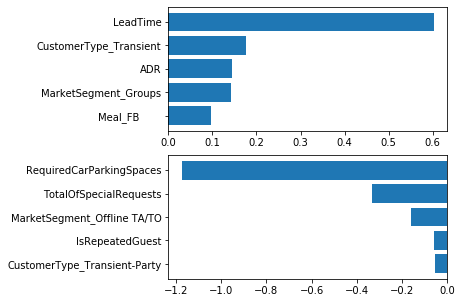

In [154]:
fig, ax = plt.subplots(2,1,figsize=(5,5))
ax[0].barh(Resort_lasso_std_coef_ascd.index[-5:],Resort_lasso_std_coef_ascd[-5:])
ax[1].barh(Resort_lasso_std_coef_desc.index[-5:],Resort_lasso_std_coef_desc[-5:])
plt.show()

In [155]:
City_lasso = Lasso(random_state=1, alpha=0.002)
City_lasso = City_lasso.fit(City_train_X, City_train_y)
City_lasso_coef = pd.Series(data=City_lasso.coef_,index=City_train_X.columns)
City_lasso_coef = City_lasso_coef[abs(City_lasso_coef)>0]
City_lasso_coef

LeadTime                             0.001013
PreviousCancellations                0.151532
PreviousBookingsNotCanceled         -0.015981
BookingChanges                      -0.066912
DaysInWaitingList                    0.000037
ADR                                  0.000758
RequiredCarParkingSpaces            -0.174389
TotalOfSpecialRequests              -0.158122
Stays                                0.010749
ArrivalDateMonth_April               0.012420
ArrivalDateMonth_July               -0.028185
ArrivalDateMonth_September          -0.004325
Meal_HB                             -0.001973
MarketSegment_Direct                -0.096128
MarketSegment_Groups                 0.183035
DistributionChannel_TA/TO            0.064737
ReservedRoomType_A                   0.006995
ReservedRoomType_D                  -0.004423
CustomerType_Transient               0.065695
CustomerType_Transient-Party        -0.232904
ArrivalDay_Friday                    0.017120
ArrivalDay_Monday                 

In [156]:
print("*** Lasso Model Result - City ***")
print("Accuracy Score - train: %.1f%%, test: %.1f%%" \
      % (accuracy_score(City_train_y,(City_lasso.predict(City_train_X)>0.5)*1)*100,
        accuracy_score(City_test_y,(City_lasso.predict(City_test_X)>0.5)*1)*100))

print("AUC Score - train: %.1f%%, test: %.1f%%"\
      %(roc_auc_score(City_train_y,City_lasso.predict(City_train_X))*100,
      roc_auc_score(City_test_y,City_lasso.predict(City_test_X))*100))

*** Lasso Model Result - City ***
Accuracy Score - train: 77.4%, test: 76.9%
AUC Score - train: 82.0%, test: 81.5%


In [157]:
num = City.select_dtypes(exclude="object").drop("IsCanceled",axis=1).columns
City_vif = [variance_inflation_factor(City_X[num].values, i) for i in range(City_X[num].shape[1])]
City_vif = pd.DataFrame({"feature":City_X[num].columns,"vif":City_vif})
City_vif.sort_values(by="vif", ascending=False)

,feature,vif
1,Adults,9.762463
9,ADR,7.426773
12,Stays,3.432057
0,LeadTime,2.167198
11,TotalOfSpecialRequests,1.642401
6,PreviousBookingsNotCanceled,1.423137
4,IsRepeatedGuest,1.312969
5,PreviousCancellations,1.295367
2,Children,1.190937
7,BookingChanges,1.116509


In [158]:
city_adults = sm.OLS(City["Adults"],pd.get_dummies(City.drop("Adults",axis=1), drop_first=True)).fit()
city_adults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Adults   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                          2.733e+04
Date:                Tue, 08 Sep 2020   Prob (F-statistic):                        0.00
Time:                        11:46:16   Log-Likelihood:                         -47634.
No. Observations:               79302   AIC:                                  9.537e+04
Df Residuals:                   79250   BIC:                                  9.586e+04
Df Model:                          52                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
IsCanceled                            0.0051      0.004      1.338      0.181      -0.002       0.012
LeadTime                              0.0006   1.77e-05     35.991      0.000       0.001       0.001
Children                             -0.2078      0.006    -35.256      0.000      -0.219      -0.196
Babies                                0.0511      0.019      2.731      0.006       0.014       0.088
IsRepeatedGuest                      -0.1049      0.012     -8.728      0.000      -0.128      -0.081
PreviousCancellations                 0.0235      0.004      5.385      0.000       0.015       0.032
PreviousBookingsNotCanceled          -0.0086      0.001     -7.664      0.000      -0.011      -0.006
BookingChanges                       -0.0670      0.003    -25.276      0.000      -0.072      -0.062
DaysInWaitingList                     0.0002    7.8e-05      3.092      0.002    8.82e-05       0.000
ADR                                   0.0020   4.84e-05     41.577      0.000       0.002       0.002
RequiredCarParkingSpaces              0.0646      0.010      6.233      0.000       0.044       0.085
TotalOfSpecialRequests                0.0553      0.002     23.407      0.000       0.051       0.060
Stays                                 0.0102      0.001     11.588      0.000       0.008       0.012
ArrivalDateMonth_August               0.0834      0.007     11.970      0.000       0.070       0.097
ArrivalDateMonth_December             0.0401      0.009      4.647      0.000       0.023       0.057
ArrivalDateMonth_February             0.0081      0.008      0.984      0.325      -0.008       0.024
ArrivalDateMonth_January             -0.0406      0.009     -4.539      0.000      -0.058      -0.023
ArrivalDateMonth_July                 0.0603      0.007      8.424      0.000       0.046       0.074
ArrivalDateMonth_June                -0.0567      0.007     -7.934      0.000      -0.071      -0.043
ArrivalDateMonth_March                0.0113      0.008      1.498      0.134      -0.003       0.026
ArrivalDateMonth_May                 -0.0861      0.007    -12.163      0.000      -0.100      -0.072
ArrivalDateMonth_November            -0.1003      0.008    -11.822      0.000      -0.117      -0.084
ArrivalDateMonth_October             -0.0444      0.007     -6.149      0.000      -0.059      -0.030
ArrivalDateMonth_September           -0.0216      0.007     -2.967      0.003      -0.036      -0.007
Meal_FB                              -0.4387      0.067     -6.544      0.000      -0.570      -0.307
Meal_HB                               0.0207      0.006      3.308      0.001       0.008       0.033
Meal_SC                   

In [160]:
City_X_std = City_X.copy()
minmax=preprocessing.MinMaxScaler()
City_X_std[num] = minmax.fit_transform(City_X[num])

In [161]:
City_lasso_std = Lasso(random_state=1, alpha=0.002)
City_lasso_std = City_lasso_std.fit(City_X_std, City_y)
City_lasso_std_coef = pd.Series(data=City_lasso_std.coef_,index=City_X_std.columns)
City_lasso_std_coef = City_lasso_std_coef[abs(City_lasso_std_coef)>0]
City_lasso_std_coef_desc = City_lasso_std_coef.sort_values(ascending=False)
City_lasso_std_coef_ascd = City_lasso_std_coef.sort_values(ascending=True)

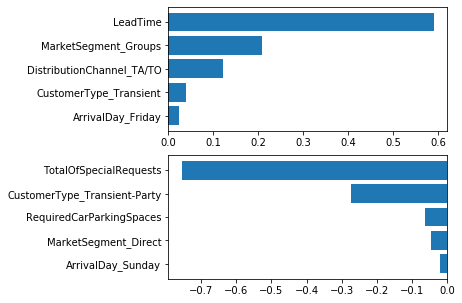

In [162]:
fig, ax = plt.subplots(2,1,figsize=(5,5))
ax[0].barh(City_lasso_std_coef_ascd.index[-5:],City_lasso_std_coef_ascd[-5:])
ax[1].barh(City_lasso_std_coef_desc.index[-5:],City_lasso_std_coef_desc[-5:])
plt.show()

In [29]:
Resort_dt = DecisionTreeClassifier(random_state=1,max_depth=9)
Resort_dt.fit(Resort_train_X,Resort_train_y)

DecisionTreeClassifier(max_depth=9, random_state=1)

In [30]:
print("Accuracy Score:", round(accuracy_score(Resort_test_y,Resort_dt.predict(Resort_test_X)),2))
print("AUC Score", round(roc_auc_score(Resort_test_y,Resort_dt.predict_proba(Resort_test_X)[:,1]),2))

Accuracy Score: 0.82
AUC Score 0.87


In [51]:
Resort_dt_importance = pd.DataFrame({"feature":Resort_X.columns,"importances":Resort_dt.feature_importances_})
Resort_dt_importance.sort_values(by="importances",ascending=False)[:10]

,feature,importances
0,LeadTime,0.224257
10,RequiredCarParkingSpaces,0.136224
51,CustomerType_Transient,0.130838
33,MarketSegment_Groups,0.109092
35,MarketSegment_Online TA,0.095605
11,TotalOfSpecialRequests,0.093108
5,PreviousCancellations,0.084131
9,ADR,0.040079
7,BookingChanges,0.026960
12,Stays,0.011846


In [81]:
param_grid = { 
    'n_estimators' : [500],
    'max_depth' : [20,22,24,26],
    'criterion' :['gini', 'entropy'],
    'min_samples_split' : [2,4,6]
}
Resort_rf_grid = GridSearchCV(estimator=RandomForestClassifier(
                                random_state=1,
                                n_jobs=-1),
                              param_grid=param_grid, 
                              cv=3).fit(Resort_train_X, Resort_train_y)
print("Best Parameters :",Resort_rf_grid.best_params_)
print("Mean CV score :",Resort_rf_grid.best_score_)

Best Parameters : {'criterion': 'gini', 'max_depth': 22, 'min_samples_split': 2, 'n_estimators': 500}
Mean CV score : 0.8496969430912156


In [83]:
rf = RandomForestClassifier(random_state=1)
Resort_rf = rf.set_params(**Resort_rf_grid.best_params_).fit(Resort_train_X, Resort_train_y)
print("Accuracy Score:", round(accuracy_score(Resort_test_y,Resort_rf.predict(Resort_test_X)),2))
print("AUC Score", round(roc_auc_score(Resort_test_y,Resort_rf.predict_proba(Resort_test_X)[:,1]),2))
print("F1 Score", round(f1_score(Resort_test_y,Resort_rf.predict(Resort_test_X)),2))

Accuracy Score: 0.86
AUC Score 0.91
F1 Score 0.72


In [265]:
City_lr = Logit(City_train_y, City_train_X).fit()
City_lr.summary()

         Current function value: 0.483725
         Iterations: 35


C:\Users\yeong\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\yeong\Anaconda3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             IsCanceled   No. Observations:                59476
Model:                          Logit   Df Residuals:                    59423
Method:                           MLE   Df Model:                           52
Date:                Fri, 04 Sep 2020   Pseudo R-squ.:                  0.2874
Time:                        11:29:14   Log-Likelihood:                -28770.
converged:                      False   LL-Null:                       -40374.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
LeadTime                              0.0059      0.000     46.446      0.000       0.006       0.006
Adults                               -0.0528      0.023     -2.266      0.023      -0.098      -0.007
Children                             -0.0032      0.039     -0.081      0.935      -0.079       0.073
Babies                                0.0578      0.138      0.419      0.675      -0.212       0.328
IsRepeatedGuest                      -0.6620      0.126     -5.272      0.000      -0.908      -0.416
PreviousCancellations                 2.8407      0.074     38.532      0.000       2.696       2.985
PreviousBookingsNotCanceled          -0.4748      0.032    -14.931      0.000      -0.537      -0.412
BookingChanges                       -0.5089      0.024    -21.641      0.000      -0.555      -0.463
DaysInWaitingList                     0.0007      0.001      1.257      0.209      -0.000       0.002
ADR                                   0.0109      0.000     25.720      0.000       0.010       0.012
RequiredCarParkingSpaces            -53.3903   9.88e+04     -0.001      1.000   -1.94e+05    1.94e+05
TotalOfSpecialRequests               -0.9567      0.017    -56.633      0.000      -0.990      -0.924
Stays                                 0.0658      0.006     11.600      0.000       0.055       0.077
ArrivalDateMonth_April                0.0204        nan        nan        nan         nan         nan
ArrivalDateMonth_August              -0.2832        nan        nan        nan         nan         nan
ArrivalDateMonth_December             0.0861        nan        nan        nan         nan         nan
ArrivalDateMonth_February             0.1554        nan        nan        nan         nan         nan
ArrivalDateMonth_January              0.2712        nan        nan        nan         nan         nan
ArrivalDateMonth_July                -0.4914        nan        nan        nan         nan         nan
ArrivalDateMonth_June                -0.1641        nan        nan        nan         nan         nan
ArrivalDateMonth_March               -0.0812        nan        nan        nan         nan         nan
ArrivalDateMonth_May                 -0.2806        nan        nan        nan         nan         nan
ArrivalDateMonth_November            -0.1611        nan        nan        nan         nan         nan
ArrivalDateMonth_October             -0.0433        nan        nan        nan         nan         nan
ArrivalDateMonth_September           -0.3376        nan        nan        nan         nan         nan
Meal_BB                               0.5714        nan        nan        nan         nan         nan
Meal_FB                               3.8848        nan        nan        nan         nan         nan
Meal_HB                               0.3492        nan        nan        nan         nan         nan
Meal_SC                               0.7350        nan        nan        nan  

In [ ]:
Resort_lr_X = Resort.drop(["DistributionChannel","ReservedRoomType","Meal","MarketSegment","CustomerType","RequiredCarParkingSpaces",\
               "Babies","IsCanceled"], axis=1)
Resort_lr_X = pd.get_dummies(Resort_lr_X)
Resort_train_lr_X, Resort_test_lr_X, Resort_train_y, Resort_test_y = train_test_split(Resort_lr_X, Resort_y, train_size=0.8, random_state=1)

In [258]:
param_grid = { 
    'n_estimators' : [500],
    'max_depth' : [20,22,24,26],
    'criterion' :['gini', 'entropy'],
    'min_samples_split' : [2,4,6]
}
df_rf_grid = GridSearchCV(estimator=RandomForestClassifier(
                                random_state=1,
                                n_jobs=-1),
                              param_grid=param_grid, 
                              cv=3).fit(df_train_X, df_train_y)
print("Best Parameters :",df_rf_grid.best_params_)
print("Mean CV score :",df_rf_grid.best_score_)

Best Parameters : {'criterion': 'gini', 'max_depth': 26, 'min_samples_split': 2, 'n_estimators': 500}
Mean CV score : 0.8524889863295915


In [260]:
rf = RandomForestClassifier(random_state=1)
df_rf = rf.set_params(**df_rf_grid.best_params_).fit(df_train_X, df_train_y)
print("Accuracy Score:", round(accuracy_score(df_test_y,df_rf.predict(df_test_X)),2))
print("AUC Score", round(roc_auc_score(df_test_y,df_rf.predict_proba(df_test_X)[:,1]),2))
print("F1 Score", round(f1_score(df_test_y,df_rf.predict(df_test_X)),2))

Accuracy Score: 0.86
AUC Score 0.93
F1 Score 0.79
